# Import Librarys

In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import regularizers

# Load data and convert data

In [2]:
DATASET_PATH = "/kaggle/input/animals10/raw-img" 

In [4]:
# Create dataframe for image and it is label
def convert_img_to_df(dataset):
    filepaths = list(Path(dataset).glob('**/*.jpg')) + \
                list(Path(dataset).glob('**/*.jpeg')) + \
                list(Path(dataset).glob('**/*.JPG')) + \
                list(Path(dataset).glob('**/*.PNG')) + \
                list(Path(dataset).glob('**/*.png')) + \
                list(Path(dataset).glob('**/*.JPEG'))

    filepaths = [str(f) for f in filepaths]  

    # Extract labels (folder names)
    labels = [os.path.basename(os.path.dirname(f)) for f in filepaths]

    df = pd.DataFrame({'filepath': filepaths, 'label': labels})
    return df

# Convert dataset into DataFrame
df = convert_img_to_df(DATASET_PATH)


In [5]:
# Convert label into english
translate = {
    "cane": "dog", 
    "cavallo": "horse", 
    "elefante": "elephant", 
    "farfalla": "butterfly", 
    "gallina": "chicken", 
    "gatto": "cat", 
    "mucca": "cow", 
    "pecora": "sheep", 
    "scoiattolo": "squirrel", 
    "ragno": "spider"
}

df['label'] = df['label'].map(translate)

In [6]:
df

,filepath,label
0,/kaggle/input/animals10/raw-img/pecora/eb31b90...,sheep
1,/kaggle/input/animals10/raw-img/pecora/eb36b80...,sheep
2,/kaggle/input/animals10/raw-img/pecora/ea37b10...,sheep
3,/kaggle/input/animals10/raw-img/pecora/eb3db10...,sheep
4,/kaggle/input/animals10/raw-img/pecora/ea36b70...,sheep
...,...,...
26174,/kaggle/input/animals10/raw-img/farfalla/eb32b...,butterfly
26175,/kaggle/input/animals10/raw-img/farfalla/ea36b...,butterfly
26176,/kaggle/input/animals10/raw-img/farfalla/eb32b...,butterfly
26177,/kaggle/input/animals10/raw-img/farfalla/eb32b...,butterfly


# EDA

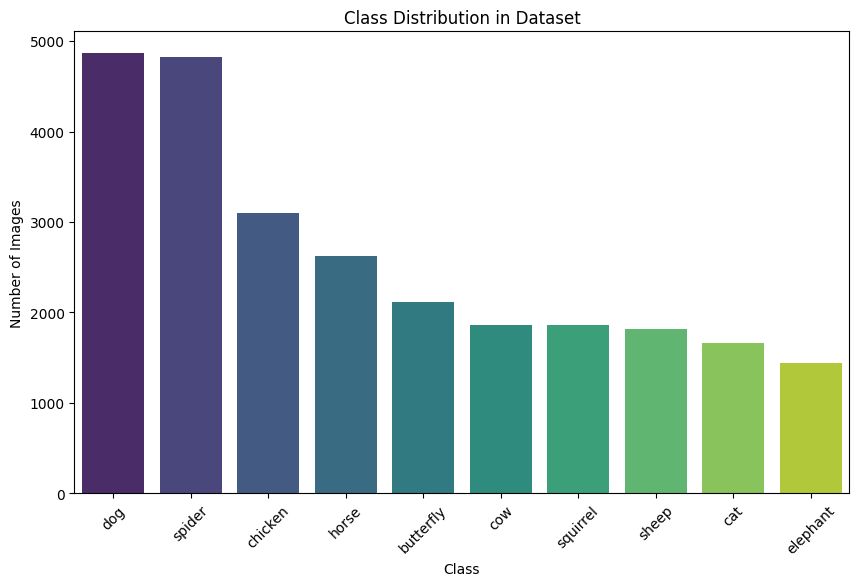

In [6]:
# show distribution of dataset
class_counts = df['label'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title("Class Distribution in Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()


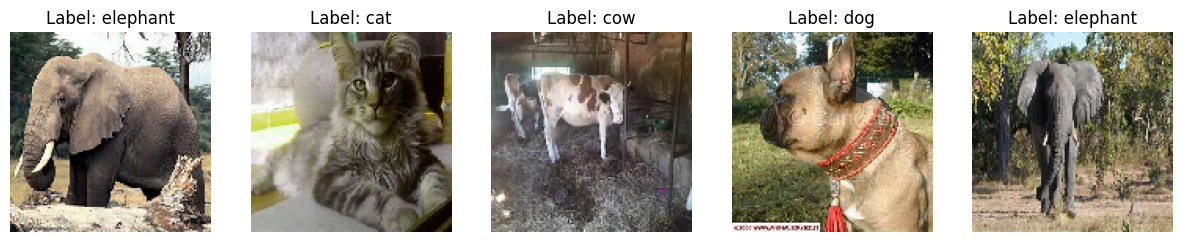

In [7]:
# Plot sample of image
sample_images = df.sample(5)  

plt.figure(figsize=(15, 10))

for i, (idx, row) in enumerate(sample_images.iterrows()):
    img_path = row['filepath']
    label = row['label']
    
    img = image.load_img(img_path, target_size=(128, 128))  # resize 
    img_array = image.img_to_array(img) / 255.0  

    plt.subplot(1, 5, i+1)
    plt.imshow(img_array)
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.show()

# Image Preprocessing

In [7]:
# Split the dataset (15% test)
train_df, test_df = train_test_split(df, test_size=0.15, stratify=df['label'], random_state=42)


In [9]:
# ImageDataGenerator with augmentation & preprocessing
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.15,  # 15% validation from train
    rescale=1./255
)
# ImageDataGenerator with only scalling
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rescale=1./255
)


In [10]:
# Create the data generator with image and label information 

train_data = train_generator.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training',
)

val_data = train_generator.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='validation',
)

test_data = test_generator.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
)


Found 18915 validated image filenames belonging to 10 classes.
Found 3337 validated image filenames belonging to 10 classes.
Found 3927 validated image filenames belonging to 10 classes.


In [9]:
print("Class Labels:", train_data.class_indices)

Class Labels: {'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 'elephant': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}


# Model Architecture (CNN)

In [11]:

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    GlobalAveragePooling2D(),  

    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),# to prevent overfitting
    Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.001))
])



learning_rate = 0.00001  
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 458,698 (1.75 MB)

 Trainable params: 457,738 (1.75 MB)

 Non-trainable params: 960 (3.75 KB)

# Model Training


In [ ]:
# monitor the validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# reduce learning rate if the validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[early_stopping,reduce_lr]
)


# Model Evaluation


In [22]:
train_loss, train_acc = model.evaluate(train_data)
print(f"Train Accuracy: {train_acc:.2f}")
print(f"Train Loss: {train_loss:.2f}")

val_loss, val_acc = model.evaluate(val_data)
print(f"Validation Accuracy: {val_acc:.2f}")
print(f"Validation Loss: {val_loss:.2f}")

test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.2f}")


592/592 ━━━━━━━━━━━━━━━━━━━━ 100s 169ms/step - accuracy: 0.7867 - loss: 1.1125
Train Accuracy: 0.79
Train Loss: 1.11
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 166ms/step - accuracy: 0.7150 - loss: 1.3140
Validation Accuracy: 0.72
Validation Loss: 1.28
123/123 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - accuracy: 0.6775 - loss: 1.4135
Test Accuracy: 0.67
Test Loss: 1.44


The model shows modaret performance on training data, but struggles to generalize well to the validation and test sets.

123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step


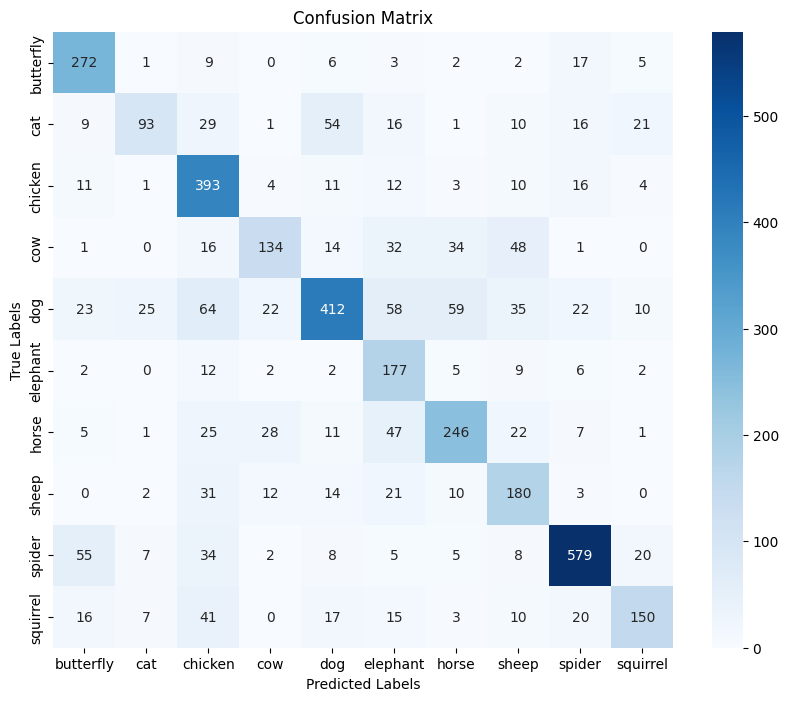

Classification Report:
              precision    recall  f1-score   support

   butterfly       0.69      0.86      0.77       317
         cat       0.68      0.37      0.48       250
     chicken       0.60      0.85      0.70       465
         cow       0.65      0.48      0.55       280
         dog       0.75      0.56      0.64       730
    elephant       0.46      0.82      0.59       217
       horse       0.67      0.63      0.65       393
       sheep       0.54      0.66      0.59       273
      spider       0.84      0.80      0.82       723
    squirrel       0.70      0.54      0.61       279

    accuracy                           0.67      3927
   macro avg       0.66      0.66      0.64      3927
weighted avg       0.69      0.67      0.67      3927



In [23]:
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1) 

true_classes = test_data.classes

# Plot Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=test_data.class_indices.keys())
print("Classification Report:")
print(report)


The model's performance is moderate, with an overall accuracy of 67%. It performs well on certain classes like elephant and butterfly but struggles with others, such as cat and cow.

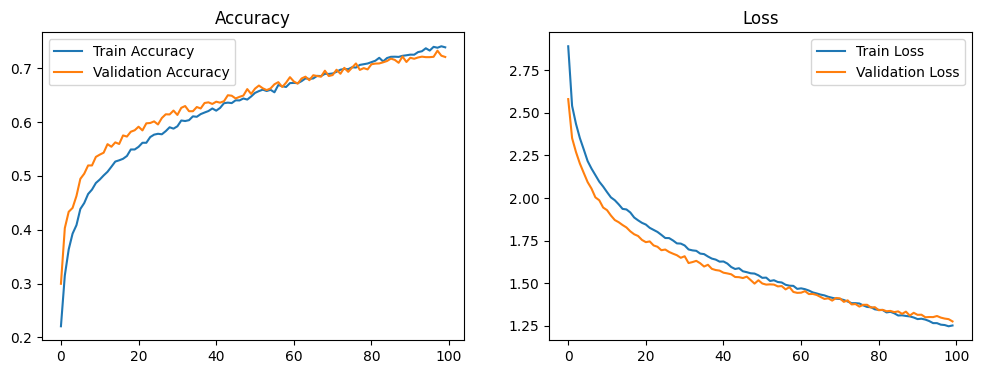

In [24]:
# Accuracy and loss curve
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


The model fit good with data

In [25]:
model.save('/kaggle/working/CNN.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


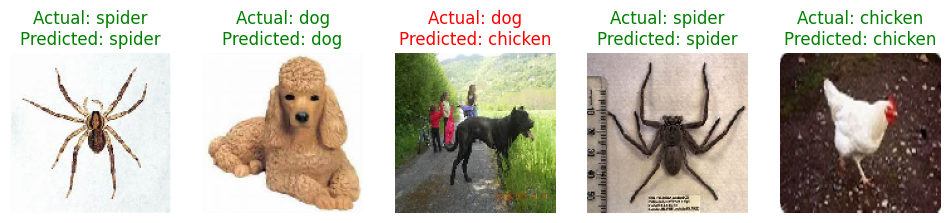

In [30]:
class_indices = {'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 
                 'elephant': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}

index_to_class = {v: k for k, v in class_indices.items()}  

images, labels = next(test_data)  

predictions = model.predict(images)
predicted_classes = np.argmax(predictions, axis=1) 

predicted_labels = [index_to_class[idx] for idx in predicted_classes]  

actual_classes = np.argmax(labels, axis=1)  
actual_labels = [index_to_class[idx] for idx in actual_classes]  

num_images = min(5, len(images))  
plt.figure(figsize=(12, 6))

for i in range(num_images):
    img = images[i]  

    plt.subplot(1, num_images, i + 1)
    plt.imshow(img)
    plt.axis("off")

    color = "green" if actual_labels[i] == predicted_labels[i] else "red"
    plt.title(f"Actual: {actual_labels[i]}\nPredicted: {predicted_labels[i]}", color=color)

plt.show()


The model performs well, but it makes some incorrect predictions.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


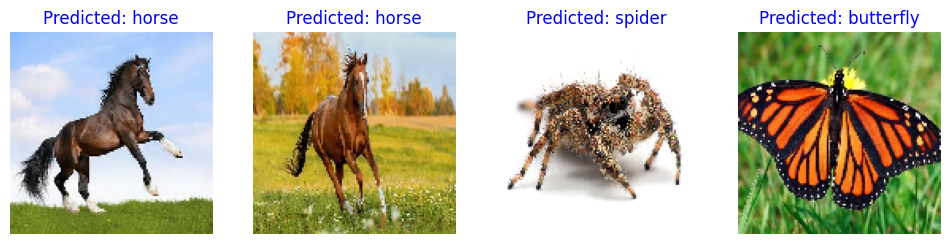

In [31]:
test_folder = "/kaggle/input/prediction"  

class_indices = {'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 
                 'elephant': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}
index_to_class = {v: k for k, v in class_indices.items()}  

image_files = [f for f in os.listdir(test_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

num_images = min(4, len(image_files))  

plt.figure(figsize=(12, 6))

for i in range(num_images):
    img_path = os.path.join(test_folder, image_files[i])

    img = load_img(img_path, target_size=(128, 128))  # Resize to match model input size
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)  
    predicted_label = index_to_class[predicted_class]  

    plt.subplot(1, num_images, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {predicted_label}", color="blue")

plt.show()


# Transfer learning (MobileNet)


In [12]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

base_model.trainable = False  

x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduce dimensions
x = BatchNormalization()(x)  # Normalize activations
x = Dropout(0.4)(x)  # Dropout to prevent overfitting
predictions = Dense(10, activation='softmax')(x)  # output layer

model2 = Model(inputs=base_model.input, outputs=predictions)

model2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 64, 64, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 64, 64, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 64, 64, 64)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 64, 64, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 65, 65, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 32, 32, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 32, 32, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 32, 32, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 32, 32, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 32, 32, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 32, 32, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 32, 32, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,243,210 (12.37 MB)

 Trainable params: 12,298 (48.04 KB)

 Non-trainable params: 3,230,912 (12.32 MB)

# Model Training

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

history2 = model2.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stopping,reduce_lr]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


592/592 ━━━━━━━━━━━━━━━━━━━━ 120s 191ms/step - accuracy: 0.3117 - loss: 2.3649 - val_accuracy: 0.7824 - val_loss: 0.6815 - learning_rate: 1.0000e-04
Epoch 2/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 110s 185ms/step - accuracy: 0.7255 - loss: 0.8439 - val_accuracy: 0.8541 - val_loss: 0.4479 - learning_rate: 1.0000e-04
Epoch 3/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 111s 185ms/step - accuracy: 0.8003 - loss: 0.5990 - val_accuracy: 0.8891 - val_loss: 0.3607 - learning_rate: 1.0000e-04
Epoch 4/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 110s 185ms/step - accuracy: 0.8421 - loss: 0.4788 - val_accuracy: 0.9050 - val_loss: 0.3062 - learning_rate: 1.0000e-04
Epoch 5/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 111s 185ms/step - accuracy: 0.8653 - loss: 0.4249 - val_accuracy: 0.9062 - val_loss: 0.2887 - learning_rate: 1.0000e-04
Epoch 6/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 111s 185ms/step - accuracy: 0.8721 - loss: 0.3994 - val_accuracy: 0.9128 - val_loss: 0.2653 - learning_rate: 1.0000e-04
Epoch 7/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 110s 184ms/

# Model Evaluation

In [14]:
train_loss, train_acc = model2.evaluate(train_data)
print(f"Train Accuracy: {train_acc:.2f}")
print(f"Train Loss: {train_loss:.2f}")

val_loss, val_acc = model2.evaluate(val_data)
print(f"Validation Accuracy: {val_acc:.2f}")
print(f"Validation Loss: {val_loss:.2f}")

test_loss, test_acc = model2.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.2f}")


592/592 ━━━━━━━━━━━━━━━━━━━━ 91s 154ms/step - accuracy: 0.9562 - loss: 0.1352
Train Accuracy: 0.95
Train Loss: 0.14
105/105 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 0.9428 - loss: 0.1878
Validation Accuracy: 0.94
Validation Loss: 0.20
123/123 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - accuracy: 0.9431 - loss: 0.1891
Test Accuracy: 0.94
Test Loss: 0.19


The model demonstrates strong performance with high accuracy (95% on training, 94% on validation and test sets), indicating effective learning and generalization.

123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step
Classification Report:
              precision    recall  f1-score   support

         dog       0.94      0.97      0.95       317
       horse       0.93      0.92      0.93       250
    elephant       0.98      0.94      0.96       465
   butterfly       0.88      0.91      0.89       280
     chicken       0.93      0.94      0.94       730
         cat       0.93      0.93      0.93       217
         cow       0.91      0.94      0.93       393
       sheep       0.88      0.90      0.89       273
      spider       0.99      0.97      0.98       723
    squirrel       0.97      0.93      0.95       279

    accuracy                           0.94      3927
   macro avg       0.93      0.93      0.93      3927
weighted avg       0.94      0.94      0.94      3927



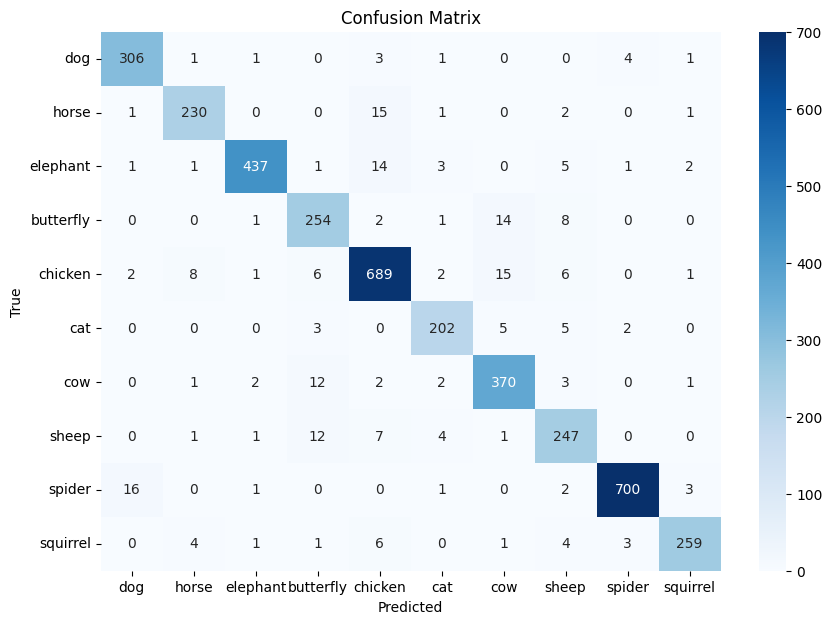

In [15]:
y_pred = model2.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)  

y_true = test_data.classes  

class_names = [
    'dog', 'horse', 'elephant', 'butterfly', 'chicken', 
    'cat', 'cow', 'sheep', 'spider', 'squirrel'
]

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


The model demonstrates excellent classification performance with an overall accuracy of 94%. Precision, recall, and F1-scores are consistently high across all classes, indicating balanced predictions.

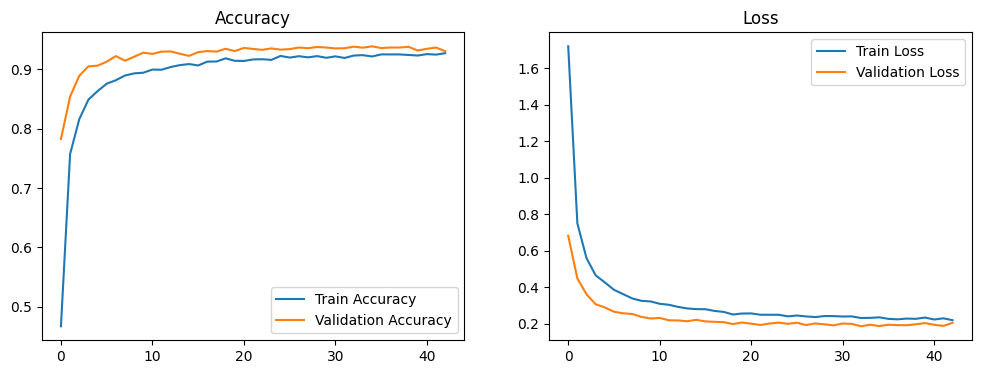

In [16]:
# Accuracy and loss curve
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


The learning curves indicate that the model generalizes well without significant overfitting or underfitting

In [53]:
model2.save('/kaggle/working/Pretriened.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


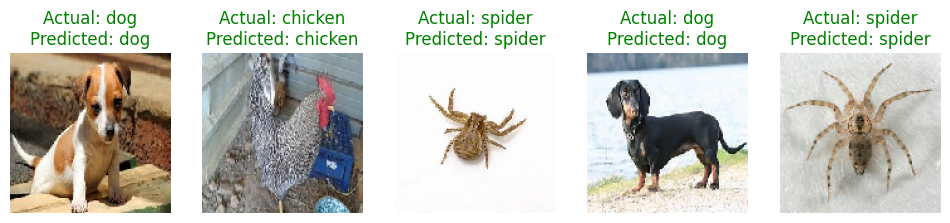

In [39]:

index_to_class = {v: k for k, v in class_indices.items()}  

images, labels = next(test_data)  

predictions = model2.predict(images)
predicted_classes = np.argmax(predictions, axis=1) 

predicted_labels = [index_to_class[idx] for idx in predicted_classes]  

actual_classes = np.argmax(labels, axis=1)  
actual_labels = [index_to_class[idx] for idx in actual_classes]  

num_images = min(5, len(images))  
plt.figure(figsize=(12, 6))

for i in range(num_images):
    img = images[i]  

    plt.subplot(1, num_images, i + 1)
    plt.imshow(img)
    plt.axis("off")

    color = "green" if actual_labels[i] == predicted_labels[i] else "red"
    plt.title(f"Actual: {actual_labels[i]}\nPredicted: {predicted_labels[i]}", color=color)

plt.show()


The prediction aligns with the actual label, indicating reliable performance on this sample.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


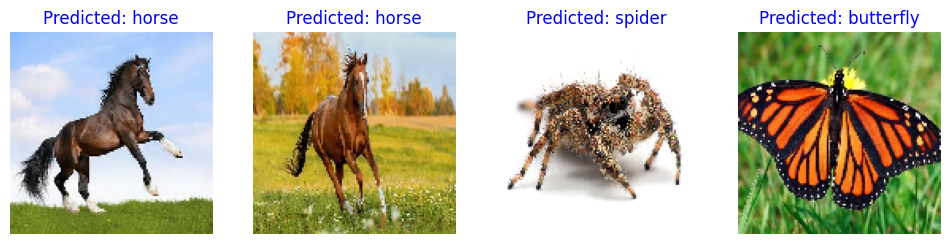

In [27]:
test_folder = "/kaggle/input/prediction"  

class_indices = {'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 
                 'elephant': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}
index_to_class = {v: k for k, v in class_indices.items()}  

image_files = [f for f in os.listdir(test_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

num_images = min(4, len(image_files))  

plt.figure(figsize=(12, 6))

for i in range(num_images):
    img_path = os.path.join(test_folder, image_files[i])

    img = load_img(img_path, target_size=(128, 128))  # Resize to match model input size
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  

    # Make prediction
    prediction = model2.predict(img_array)
    predicted_class = np.argmax(prediction)  
    predicted_label = index_to_class[predicted_class]  

    plt.subplot(1, num_images, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {predicted_label}", color="blue")

plt.show()


The model successfully classified an unseen image, demonstrating strong generalization capabilities.

# Transfer learning (ResNet50V2)


In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

# Load ResNet50V2 without the top layer (the fully connected part)
efficient_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Unfreeze some layers for fine-tuning
efficient_model.trainable = True
for layer in efficient_model.layers[:-50]:  # Unfreeze the last 50 layers
    layer.trainable = False

model3 = models.Sequential([
    efficient_model,
    GlobalAveragePooling2D(),  # Pooling the feature map
    Dropout(0.3),  #  dropout to avoid overfitting

    BatchNormalization(),  # Normalize activations
    Dense(512, activation='relu'), 
        BatchNormalization(),  # Normalize activations

    Dense(256, activation='relu'),
    BatchNormalization(),  # Normalize activations

    Dropout(0.4),  

    Dense(128, activation='relu'), 
        BatchNormalization(),  

    Dense(64, activation='relu'),  
    BatchNormalization(),  

    Dropout(0.5),
    Dense(10, activation='softmax')  # Output layer for 10 classes
])



optimizer = Adam(learning_rate=0.0001)

model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model3.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 4, 4, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,799,050 (94.60 MB)

 Trainable params: 17,580,490 (67.06 MB)

 Non-trainable params: 7,218,560 (27.54 MB)

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

history2 = model3.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stopping,reduce_lr]
)

Epoch 1/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 149s 208ms/step - accuracy: 0.2460 - loss: 2.6671 - val_accuracy: 0.7498 - val_loss: 0.7910 - learning_rate: 1.0000e-04
Epoch 2/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 110s 183ms/step - accuracy: 0.6451 - loss: 1.1637 - val_accuracy: 0.7785 - val_loss: 0.7011 - learning_rate: 1.0000e-04
Epoch 3/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 112s 187ms/step - accuracy: 0.7253 - loss: 0.9127 - val_accuracy: 0.8442 - val_loss: 0.4883 - learning_rate: 1.0000e-04
Epoch 4/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 110s 183ms/step - accuracy: 0.7955 - loss: 0.7043 - val_accuracy: 0.8687 - val_loss: 0.4392 - learning_rate: 1.0000e-04
Epoch 5/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 111s 186ms/step - accuracy: 0.8254 - loss: 0.6142 - val_accuracy: 0.8786 - val_loss: 0.4027 - learning_rate: 1.0000e-04
Epoch 6/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 111s 186ms/step - accuracy: 0.8596 - loss: 0.4950 - val_accuracy: 0.8768 - val_loss: 0.4020 - learning_rate: 1.0000e-04
Epoch 7/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 

# Model Evaluation

In [17]:
train_loss, train_acc = model3.evaluate(train_data)
print(f"Train Accuracy: {train_acc:.2f}")
print(f"Train Loss: {train_loss:.2f}")

val_loss, val_acc = model3.evaluate(val_data)
print(f"Validation Accuracy: {val_acc:.2f}")
print(f"Validation Loss: {val_loss:.2f}")

test_loss, test_acc = model3.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.2f}")


592/592 ━━━━━━━━━━━━━━━━━━━━ 92s 155ms/step - accuracy: 0.9716 - loss: 0.0952
Train Accuracy: 0.97
Train Loss: 0.09
105/105 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - accuracy: 0.8903 - loss: 0.3718
Validation Accuracy: 0.90
Validation Loss: 0.36
123/123 ━━━━━━━━━━━━━━━━━━━━ 24s 195ms/step - accuracy: 0.8996 - loss: 0.3441
Test Accuracy: 0.90
Test Loss: 0.34


123/123 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step
Classification Report:
              precision    recall  f1-score   support

         dog       0.94      0.94      0.94       317
       horse       0.86      0.85      0.86       250
    elephant       0.94      0.91      0.93       465
   butterfly       0.83      0.84      0.83       280
     chicken       0.92      0.87      0.90       730
         cat       0.92      0.87      0.89       217
         cow       0.89      0.89      0.89       393
       sheep       0.75      0.89      0.82       273
      spider       0.96      0.97      0.96       723
    squirrel       0.88      0.90      0.89       279

    accuracy                           0.90      3927
   macro avg       0.89      0.89      0.89      3927
weighted avg       0.90      0.90      0.90      3927



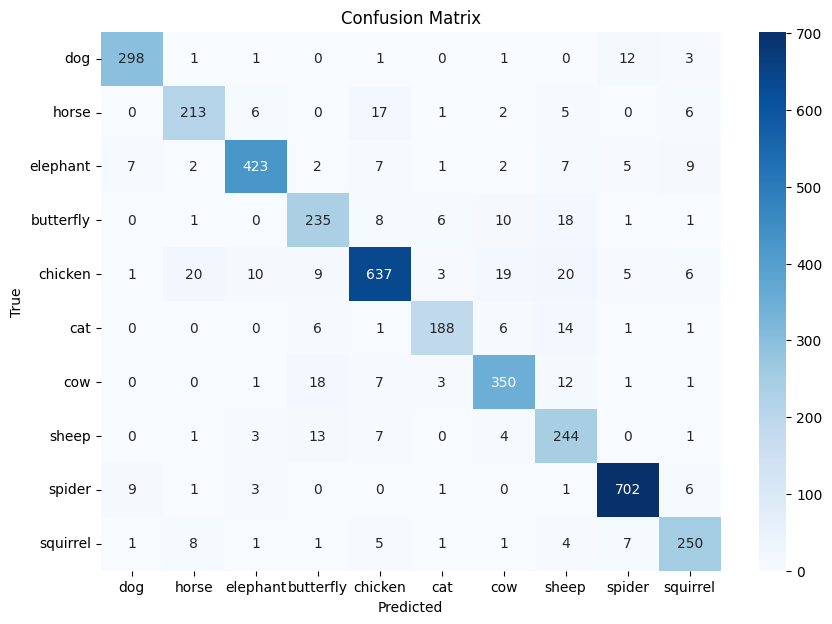

In [21]:
y_pred = model3.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)  

y_true = test_data.classes  

class_names = [
    'dog', 'horse', 'elephant', 'butterfly', 'chicken', 
    'cat', 'cow', 'sheep', 'spider', 'squirrel'
]

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


The model performs well with an overall accuracy of 90%, showing strong precision, recall, and F1-scores across most classes.

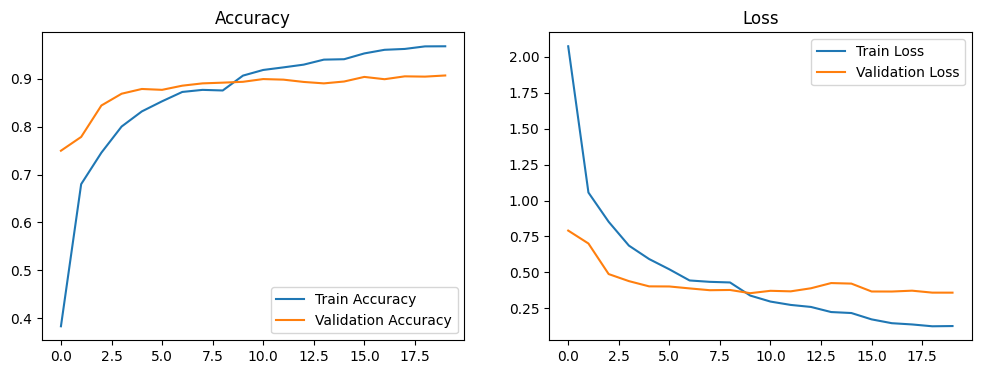

In [18]:
# Accuracy and loss curve
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [20]:
model3.save('/kaggle/working/Resnet.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


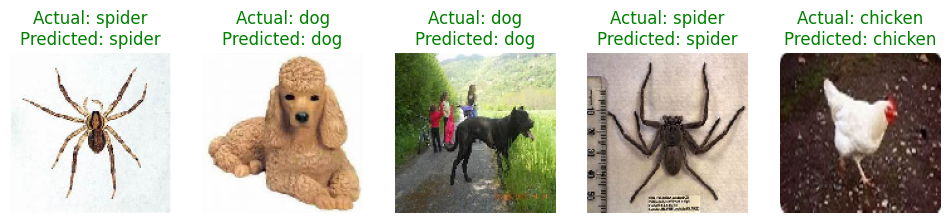

In [23]:
class_indices = {'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 
                 'elephant': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}

index_to_class = {v: k for k, v in class_indices.items()}  

images, labels = next(test_data)  

predictions = model3.predict(images)
predicted_classes = np.argmax(predictions, axis=1) 

predicted_labels = [index_to_class[idx] for idx in predicted_classes]  

actual_classes = np.argmax(labels, axis=1)  
actual_labels = [index_to_class[idx] for idx in actual_classes]  

num_images = min(5, len(images))  
plt.figure(figsize=(12, 6))

for i in range(num_images):
    img = images[i]  

    plt.subplot(1, num_images, i + 1)
    plt.imshow(img)
    plt.axis("off")

    color = "green" if actual_labels[i] == predicted_labels[i] else "red"
    plt.title(f"Actual: {actual_labels[i]}\nPredicted: {predicted_labels[i]}", color=color)

plt.show()


The prediction aligns with the actual label, indicating reliable performance on this sample.

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


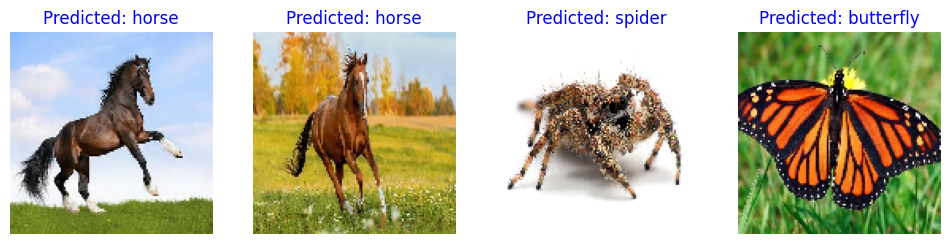

In [24]:
test_folder = "/kaggle/input/prediction"  

class_indices = {'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 
                 'elephant': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}
index_to_class = {v: k for k, v in class_indices.items()}  

image_files = [f for f in os.listdir(test_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

num_images = min(4, len(image_files))  

plt.figure(figsize=(12, 6))

for i in range(num_images):
    img_path = os.path.join(test_folder, image_files[i])

    img = load_img(img_path, target_size=(128, 128))  # Resize to match model input size
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  

    # Make prediction
    prediction = model3.predict(img_array)
    predicted_class = np.argmax(prediction)  
    predicted_label = index_to_class[predicted_class]  

    plt.subplot(1, num_images, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {predicted_label}", color="blue")

plt.show()
